In [1]:
import os
import time
import math
import itertools
import yaml
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from hypernet_MLP import Hypernet_MLP

In [2]:
def set_seed(seed=702):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(702)

# Const

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
GROUND_TRUTH_FILE = "../4_Pareto_front/test/ex4/pf_dynamic_true.npy" 

if os.path.exists(GROUND_TRUTH_FILE):
    pf_true = np.load(GROUND_TRUTH_FILE)
    print(f"✅ Đã tải ground truth Pareto front từ: {GROUND_TRUTH_FILE}, Shape: {pf_true.shape}")
else:
    print(f"❌ KHÔNG tìm thấy file ground truth tại: {GROUND_TRUTH_FILE}")

✅ Đã tải ground truth Pareto front từ: ../4_Pareto_front/test/ex4/pf_dynamic_true.npy, Shape: (20, 2)


# Def

In [6]:
import autograd.numpy as np
from scipy.optimize import minimize            
        
class Projection:
    def __init__(self, cons, bounds, dim, proj_type='euclid'):
        self.cons = cons
        self.bounds = bounds
        self.dim = dim
        self.proj_type = proj_type
        
        if self.proj_type == 'qplus':
            self.objective_func = self._obj_positive_diff
        elif self.proj_type == 'euclid':
            self.objective_func = self._obj_l2_norm
        else:
            print(f"Phép chiếu {self.objective_func} không cài đặt, chọn 'qplus' hoặc 'euclid'")

    def _obj_l2_norm(self, x, y):
        return np.sqrt(np.sum((x - y)**2))
    
    def _obj_positive_diff(self, x, y):
        v = np.maximum(y - x, 0) 
        return np.sum(v**2)

    def project(self, target_point):
        init_point = np.random.rand(1, self.dim).tolist()[0]
        
        res = minimize(
            self.objective_func,
            init_point,
            args=(target_point, ),
            constraints=self.cons,
            bounds=self.bounds,
            options={'disp': False}
        )
        
        optim_point = res.x
        
        if self.proj_type == 'qplus':
            return target_point - np.maximum(target_point - optim_point, 0)
        else:
            return optim_point

class Problem():
    def __init__(self, f, dim_x, dim_y, proj_C, proj_Qplus):
        self.f = f
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.proj_C = proj_C
        self.proj_Qplus = proj_Qplus
    
    def objective_func(self, x):
        vals = [func(x) for func in self.f]
        return np.concatenate(vals)  

In [7]:
def f1(x): return 4*x[0]**2 + 4*x[1]**2
def f2(x): return (x[0] - 5)**2 + (x[1] - 5)**2

def c1(x): return -(x[0] - 5)**2 - x[1]**2 + 25
def c2(x): return -(x[0] - 8)**2 - (x[1] + 3)**2 + 17.7

def q1(y): return 50**2 - (y[0] - 50)**2 - (y[1] - 50)**2
def q_plus(y):
    center = 50.0; radius_sq = 50**2
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

cons_C = ({'type': 'ineq', 'fun': c1}, {'type': 'ineq', 'fun': c2})
cons_Q = ({'type': 'ineq', 'fun': q1},)
cons_Qplus = ({'type': 'ineq', 'fun': q_plus},)
bounds_x = Bounds([-15,-15],[30, 30])
dim_x = 2; dim_y = 2

# Setup
proj_C_handler = Projection(cons_C, bounds_x, dim_x, 'euclid')
proj_Q_handler = Projection(cons_Q, None, dim_y, 'qplus')
prob = Problem([f1, f2], dim_x, dim_y, proj_C_handler.project, proj_Q_handler.project)
z_star = np.array([75.23366646094793, 25.502227623508944]) 

In [8]:
def evaluate_objectives_single(functions, x_tensor):
    vals = []
    for func in functions:
        val = func(x_tensor)
        if not torch.is_tensor(val): val = torch.tensor(val, dtype=torch.float32, device=x_tensor.device)
        vals.append(val)
    return torch.stack(vals).reshape(-1)

def calculate_mse_igd(pf_pred, pf_true):
    if len(pf_pred) == 0: return np.inf
    total_dist_sq = 0
    # Với mỗi điểm ground truth, tìm điểm dự đoán gần nhất
    for p_true in pf_true:
        dists_sq = np.sum((pf_pred - p_true)**2, axis=1)
        total_dist_sq += np.min(dists_sq)
    return total_dist_sq / len(pf_true)

In [9]:
def train_hypernet(hypernet, prob, z_star, 
                   num_epochs=1000, lr=1e-3, num_partitions=50, 
                   lr_step_size=300, lr_gamma=0.5,
                   init_pen_C=1.0, max_pen_C=1000.0, pen_C_growth=1.01,
                   init_pen_Q=50.0, min_pen_Q=1.0, pen_Q_decay=0.995,
                   verbose=False):
    
    hypernet = hypernet.to(device)
    optimizer = optim.Adam(hypernet.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
    z_star_tensor = torch.tensor(z_star, dtype=torch.float32, device=device).view(1, -1)
    
    current_pen_C = init_pen_C
    current_pen_Q = init_pen_Q
    angle_step = (math.pi / 2) / num_partitions
    
    for epoch in range(num_epochs):
        hypernet.train()
        optimizer.zero_grad()
        
        # 1. Stratified Sampling
        starts = torch.arange(num_partitions) * angle_step
        noise = torch.rand(num_partitions) * angle_step
        thetas = starts + noise
        r_batch_np = np.stack([np.cos(thetas.numpy()), np.sin(thetas.numpy())], axis=1)
        r_tensor_batch = torch.tensor(r_batch_np, dtype=torch.float32, device=device)
        
        # 2. Forward & Loss Calculation (Loop safe logic)
        loss_C_list = []
        loss_Q_list = []
        y_pred_list = []
        
        # Forward pass batch (Nhanh hơn gọi từng cái)
        x_vec_batch = hypernet(r_tensor_batch) # (Batch, 2)
        x_np_batch = x_vec_batch.detach().cpu().numpy()
        
        for i in range(num_partitions):
            x_i_tensor = x_vec_batch[i]
            x_i_np = x_np_batch[i]
            
            # Loss C
            x_proj_i_np = prob.proj_C(x_i_np)
            x_proj_i_tensor = torch.tensor(x_proj_i_np, dtype=torch.float32, device=device)
            loss_C_list.append(torch.sum((x_i_tensor - x_proj_i_tensor)**2))
            
            # F(x)
            y_pred_i = evaluate_objectives_single(prob.f, x_i_tensor)
            y_pred_list.append(y_pred_i)
            
            # Loss Q
            y_i_np = y_pred_i.detach().cpu().numpy()
            y_proj_i_np = prob.proj_Qplus(y_i_np)
            y_proj_i_tensor = torch.tensor(y_proj_i_np, dtype=torch.float32, device=device)
            loss_Q_list.append(torch.sum((y_pred_i - y_proj_i_tensor)**2))
            
        y_pred_batch = torch.stack(y_pred_list)
        loss_C = torch.mean(torch.stack(loss_C_list))
        loss_Q = torch.mean(torch.stack(loss_Q_list))
        
        # Chebyshev Loss
        diff = y_pred_batch - z_star_tensor
        weighted_diff = r_tensor_batch * diff
        max_vals, _ = torch.max(weighted_diff, dim=1)
        loss_obj = torch.mean(max_vals)
        
        total_loss = loss_obj + (current_pen_C * loss_C) + (current_pen_Q * loss_Q)
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Update Penalties
        current_pen_C = min(max_pen_C, current_pen_C * pen_C_growth)
        current_pen_Q = max(min_pen_Q, current_pen_Q * pen_Q_decay)
        
        if verbose and epoch % (num_epochs // 5) == 0:
            print(f"  Ep {epoch}: Loss={total_loss.item():.2f} (Obj={loss_obj.item():.2f}, C={loss_C.item():.4f})")
            
    return hypernet

In [10]:
def evaluate_model(hypernet, prob, test_rays, pf_true):
    hypernet.eval()
    pf_pred = []
    
    # Chuyển test_rays sang tensor batch để infer nhanh
    rays_tensor = torch.tensor(test_rays, dtype=torch.float32, device=device)
    
    with torch.no_grad():
        x_raw = hypernet(rays_tensor) # (N, 2)
        x_raw_np = x_raw.cpu().numpy()
        
        # Loop project and eval
        for i in range(len(x_raw_np)):
            # Chiếu lên C (Quan trọng để feasible)
            x_proj = prob.proj_C(x_raw_np[i])
            # Tính f
            val = [func(x_proj) for func in prob.f]
            pf_pred.append(val)
            
    pf_pred = np.array(pf_pred)
    igd_score = calculate_mse_igd(pf_pred, pf_true)
    return igd_score, pf_pred

# Config

In [13]:
param_grid = {
    'lr': [1e-3],
    'num_epochs': [1000],
    'pen_C_growth': [1.005, 1.01, 1.05],      # Tăng phạt C nhanh hay chậm
    'pen_Q_decay': [0.995],      
    'init_pen_C': [10.0, 50.0, 100.0],
    'init_pen_Q': [20.0, 50.0],
    'max_pen_C': [500.0, 1000.0, 2000.0]
}

config_path='../4_Pareto_front/config.yaml'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
test_rays = np.array(cfg['data']['test_ray'])

# Run

In [14]:
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"🔍 Bắt đầu Grid Search với {len(param_combinations)} cấu hình...")

results = []
best_igd = float('inf')
best_config = None
best_pf_pred = None

# --- Main Tuning Loop ---
for idx, params in enumerate(param_combinations):
    print(f"\n--- Running Config {idx+1}/{len(param_combinations)} ---")
    print(params)
    
    # 1. Init Model
    model = Hypernet_MLP(ray_hidden_dim=32, out_dim=dim_x, n_tasks=2)
    
    # 2. Train
    start_time = time.time()
    trained_model = train_hypernet(
        model, prob, z_star, 
        num_epochs=params['num_epochs'],
        lr=params['lr'],
        num_partitions=20, 
        init_pen_C=params['init_pen_C'],
        pen_C_growth=params['pen_C_growth'],
        init_pen_Q=params['init_pen_Q'],
        pen_Q_decay=params['pen_Q_decay'],
        verbose=True
    )
    train_time = time.time() - start_time
    
    # 3. Evaluate
    igd, pf_pred = evaluate_model(trained_model, prob, test_rays, pf_true)
    
    print(f"⏱️ Time: {train_time:.2f}s | 📉 IGD Score: {igd:.4f}")
    
    # Save result
    res = {
        'config_id': idx,
        'params': params,
        'igd': igd,
        'time': train_time
    }
    results.append(res)
    
    # Update Best
    if igd < best_igd:
        best_igd = igd
        best_config = params
        best_pf_pred = pf_pred
        # Lưu model tốt nhất (optional)
        torch.save(trained_model.state_dict(), "best_hypernet_tuned.pth")



🔍 Bắt đầu Grid Search với 54 cấu hình...

--- Running Config 1/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.005, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 20.0, 'max_pen_C': 500.0}
  Ep 0: Loss=210.01 (Obj=16.26, C=19.3750)
  Ep 200: Loss=3.86 (Obj=2.81, C=0.0388)
  Ep 400: Loss=3.62 (Obj=3.16, C=0.0062)
  Ep 600: Loss=3.77 (Obj=3.48, C=0.0014)
  Ep 800: Loss=3.80 (Obj=3.67, C=0.0002)
⏱️ Time: 93.45s | 📉 IGD Score: 2.9408

--- Running Config 2/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.005, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 20.0, 'max_pen_C': 1000.0}
  Ep 0: Loss=200.32 (Obj=15.20, C=18.5126)
  Ep 200: Loss=5.81 (Obj=4.68, C=0.0419)
  Ep 400: Loss=4.62 (Obj=3.58, C=0.0142)
  Ep 600: Loss=4.65 (Obj=4.08, C=0.0029)
  Ep 800: Loss=4.10 (Obj=3.86, C=0.0005)
⏱️ Time: 106.42s | 📉 IGD Score: 8.6996

--- Running Config 3/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.005, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'in

  Ep 200: Loss=11.51 (Obj=11.20, C=0.0042)
  Ep 400: Loss=7.00 (Obj=6.13, C=0.0016)
  Ep 600: Loss=5.60 (Obj=5.44, C=0.0002)
  Ep 800: Loss=5.36 (Obj=5.21, C=0.0001)
⏱️ Time: 132.72s | 📉 IGD Score: 17.7347

--- Running Config 21/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.01, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 20.0, 'max_pen_C': 2000.0}
  Ep 0: Loss=183.48 (Obj=15.53, C=16.7951)
  Ep 200: Loss=4.67 (Obj=3.74, C=0.0126)
  Ep 400: Loss=3.92 (Obj=3.78, C=0.0003)
  Ep 600: Loss=3.90 (Obj=3.86, C=0.0000)
  Ep 800: Loss=3.79 (Obj=3.75, C=0.0000)
⏱️ Time: 107.71s | 📉 IGD Score: 3.5679

--- Running Config 22/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.01, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 50.0, 'max_pen_C': 500.0}
  Ep 0: Loss=222.49 (Obj=17.11, C=20.5380)
  Ep 200: Loss=14.00 (Obj=13.85, C=0.0021)
  Ep 400: Loss=8.68 (Obj=8.64, C=0.0001)
  Ep 600: Loss=6.88 (Obj=6.65, C=0.0002)
  Ep 800: Loss=6.70 (Obj=6.50, C=0.0002)
⏱️

  Ep 200: Loss=21.73 (Obj=21.34, C=0.0004)
  Ep 400: Loss=18.71 (Obj=18.66, C=0.0000)
  Ep 600: Loss=16.79 (Obj=16.74, C=0.0000)
  Ep 800: Loss=16.19 (Obj=16.17, C=0.0000)
⏱️ Time: 160.13s | 📉 IGD Score: 315.6867

--- Running Config 41/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.05, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 50.0, 'max_pen_C': 1000.0}
  Ep 0: Loss=218.29 (Obj=15.75, C=20.2545)
  Ep 200: Loss=17.73 (Obj=17.51, C=0.0002)
  Ep 400: Loss=15.47 (Obj=15.33, C=0.0001)
  Ep 600: Loss=13.66 (Obj=13.45, C=0.0002)
  Ep 800: Loss=12.57 (Obj=12.56, C=0.0000)
⏱️ Time: 158.74s | 📉 IGD Score: 161.1044

--- Running Config 42/54 ---
{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.05, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 50.0, 'max_pen_C': 2000.0}
  Ep 0: Loss=212.85 (Obj=15.37, C=19.7483)
  Ep 200: Loss=18.95 (Obj=18.82, C=0.0001)
  Ep 400: Loss=15.89 (Obj=15.86, C=0.0000)
  Ep 600: Loss=13.93 (Obj=13.93, C=0.0000)
  Ep 800: Loss=12.87 

# Viz


🏆 BEST CONFIGURATION FOUND (IGD=2.9408)
lr: 0.001
num_epochs: 1000
pen_C_growth: 1.005
pen_Q_decay: 0.995
init_pen_C: 10.0
init_pen_Q: 20.0
max_pen_C: 500.0

Top 5 Configs:
Rank 1: IGD=2.9408 | Params={'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.005, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 20.0, 'max_pen_C': 500.0}
Rank 2: IGD=3.5679 | Params={'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.01, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 20.0, 'max_pen_C': 2000.0}
Rank 3: IGD=4.3304 | Params={'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.005, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 20.0, 'max_pen_C': 2000.0}
Rank 4: IGD=4.4644 | Params={'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.005, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 50.0, 'max_pen_C': 2000.0}
Rank 5: IGD=4.5493 | Params={'lr': 0.001, 'num_epochs': 1000, 'pen_C_growth': 1.005, 'pen_Q_decay': 0.995, 'init_pen_C': 10.0, 'init_pen_Q': 50.0, 'max_pen_

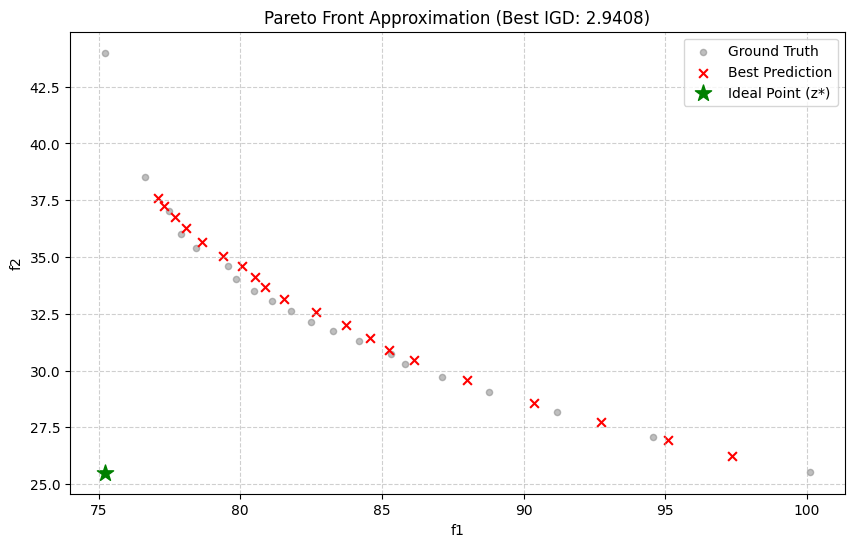

In [15]:
print("\n" + "="*40)
print(f"🏆 BEST CONFIGURATION FOUND (IGD={best_igd:.4f})")
print("="*40)
for k, v in best_config.items():
    print(f"{k}: {v}")

# Sắp xếp kết quả theo IGD
sorted_results = sorted(results, key=lambda x: x['igd'])
print("\nTop 5 Configs:")
for i in range(min(5, len(sorted_results))):
    r = sorted_results[i]
    print(f"Rank {i+1}: IGD={r['igd']:.4f} | Params={r['params']}")

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plot Ground Truth
if pf_true is not None:
    plt.scatter(pf_true[:, 0], pf_true[:, 1], c='gray', alpha=0.5, label='Ground Truth', s=20)

# Plot Best Prediction
if best_pf_pred is not None:
    plt.scatter(best_pf_pred[:, 0], best_pf_pred[:, 1], c='red', marker='x', label='Best Prediction', s=40)

# Plot Ideal Point
plt.scatter(z_star[0], z_star[1], c='green', marker='*', s=150, label='Ideal Point (z*)')

plt.xlabel('f1')
plt.ylabel('f2')
plt.title(f'Pareto Front Approximation (Best IGD: {best_igd:.4f})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [18]:
import pandas as pd

pd.DataFrame(sorted_results)

,config_id,params,igd,time
0,0,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",2.940787,93.445961
1,20,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",3.567915,107.713984
2,2,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",4.330421,98.187716
3,5,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",4.464400,96.579152
4,4,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",4.549287,100.698933
5,18,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",5.481994,119.584781
6,1,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",8.699601,106.421500
7,44,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",9.214555,135.374696
8,25,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",13.546761,132.623991
9,31,"{'lr': 0.001, 'num_epochs': 1000, 'pen_C_growt...",14.199908,133.573009
